## Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
from src.core import*

# Parameters

In [4]:
#set project variables
Project_Area = 'nebraska_regression_stantec'
GRASS_GIS_Projection = projection = '26852' #UTM meters ##set to None if you want to use the DEM's original projection
res = '10m'
## Set variables analysis
data_scale = 'HUC8' #other options HUC12, HUC10, HUC8 OR the field name of the source data to be split <-- case sensitive
select_data = '10270204' #     # Value within the filter_field used for data selection
to_headwaters = False #False if only interested in local huc area
input_shp_name = 'None' #None or must be populated populated with a shapefile polygons if data_scale != HUCXX
buffer = 2000*3.28084 #untis of projection
auto_delete = False

In [4]:
## GRASSGIS Location and Mapsets
Location = Project_Area+'_'+GRASS_GIS_Projection
Mapset = 'PERMANENT'
jobs =['Local','NonLocal']#

## Paths:
parent_dir = pl.Path('/home/jovyan/app/data')
current_dir = pl.Path(os.getcwd())
outputs_dir =parent_dir/'Rasters'/Project_Area/'Outputs'
vector_dir = parent_dir/'Vectors'/Project_Area
raster_dir = parent_dir/'Rasters'/Project_Area
git_data_repo = current_dir/'data_repository'
directory = outputs_dir

### Start new grass session

In [5]:
initialize_grass_db(Location, Mapset, GRASS_GIS_Projection)

Database Location Exists
Database Mapset Exists


#### Review existing files

In [6]:
#list all grass files
grass_maps = list_existing_grass()

Available vector maps:
HUC120203@PERMANENT
WBDHU12@PERMANENT
basins@PERMANENT
basins_buffer@PERMANENT
outletsmapvec@PERMANENT
tmp_bsn@PERMANENT
tmp_bsn_buffer@PERMANENT
tmp_huc@PERMANENT
tmp_huc_buffer@PERMANENT
tmp_huc_buffer_nhd@PERMANENT
tmp_huc_sm_buff@PERMANENT
v_020301050103_HUC_Boundary@PERMANENT
v_020301050103upstream_HUC_Boundaries@PERMANENT
v_020301050103upstream_HUC_Boundaries_buffer@PERMANENT
v_020301050103upstream_nhd@PERMANENT
v_HUC12_Boundaries@PERMANENT
v_HUC_12_pour_points@PERMANENT
v_HUC_12_pour_points_upstream@PERMANENT
v_nhd@PERMANENT
v_stream_020301050103@PERMANENT

Available raster maps:
MASK@PERMANENT
basin_020301050103@PERMANENT
dem_020301050103@PERMANENT
outletmap@PERMANENT
outlets@PERMANENT
outlets_accum@PERMANENT
r_accum_020301050103@PERMANENT
r_drain_dir_020301050103@PERMANENT
r_drain_dir_020301050103_tight@PERMANENT
wsd_filt_dem_020301050103_b@PERMANENT


In [7]:
#remove old files if needed
remove_grass_data(grass_maps,'None','vector') #all as 

In [8]:
#Define file Names
huc12s = 'v_HUC12_Boundaries'
upstream_huc12s = 'v_'+select_data+'upstream_HUC_Boundaries'
selected_huc12 = 'v_'+select_data+'_HUC_Boundary'
nhd = 'v_nhd'
upstream_nhd = 'v_'+select_data+'upstream_nhd'
pour_points = 'v_HUC_12_pour_points'
pour_points_upstream = 'v_HUC_12_pour_points_upstream'
selected_pour_points = 'v_'+select_data+'_HUC_12_pour_points'

### Get NHD data

In [10]:
#download NHD geodatabase if not already saved
wbd = nhd_download(select_data,vector_dir)

gdb is already downloaded


In [11]:
#read in HUC12s vector file from NHD
local_huc4 = gpd.read_file(vector_dir/wbd, layer='WBDHU12')

In [12]:
#reformat fields to handle disparate USGS data formats
local_huc4 = lower_pd_cols(local_huc4)

In [13]:
## function to get most downstream HUC12 if HUC10 or HUC8 is entered
select_data = get_downstream_huc12(select_data,local_huc4)

In [14]:
#get upstream HUC12 watersheds
upstream_list = get_upstream_extent_usgs(select_data) #selected huc12

searching for upstream huc12 basins
found 1 upstream huc12s


In [15]:
#import relevant NHD files for analysis
nhd_to_grass(git_data_repo,vector_dir,select_data,upstream_list,huc12s,selected_huc12,upstream_huc12s,pour_points,pour_points_upstream,nhd,upstream_nhd,force='Yes') # add 'Yes' optional parameter if you want to force recreate

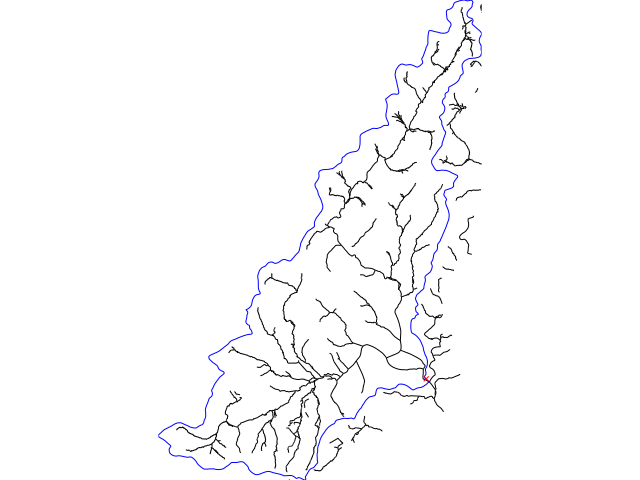

In [16]:
##print watershed flowlines @ Regional scale to confirm data and extent
gs.parse_command('g.region',vector = upstream_huc12s)
gs.run_command('d.erase')
gs.run_command('d.vect', map= upstream_huc12s,color='blue',fill_color='none')
gs.run_command('d.vect', map= upstream_nhd,color='black',fill_color='none')
gs.run_command('d.vect', map= pour_points_upstream,color='red',fill_color='none')
Image(filename="map.png")

### Get Raster data

#### Must first run DEM Download Notebook at
[DEM Download](DEM_download.ipynb#section_id1)
<a id='section_id1'></a>

#### Must first run RAS_DEM_Prep Download Notebook at
[RAS_DEM Prep](RAS_DEM_Prep.ipynb#section_id1)
<a id='section_id1'></a>

## Calculate Watershed Attributes and Stream Network

In [17]:
# processing for each HUC-12 individually
huc_key = grass_watershed_processing(data_scale,upstream_list,upstream_huc12s,upstream_nhd,vector_dir,raster_dir,filter_size = 27, carve = True, force=False) #last 3 are optional parameters. filter size in meters

Median filtering of mesh for 020301050103
Processing stream lines for 020301050103
Carving DEM for 020301050103
Getting watershed information for 020301050103
Identifying outlet point for 020301050103
Delineating basin according to outlet for 020301050103
Exporting basin as tiff
Patching huc12s for export


## Plot the Results

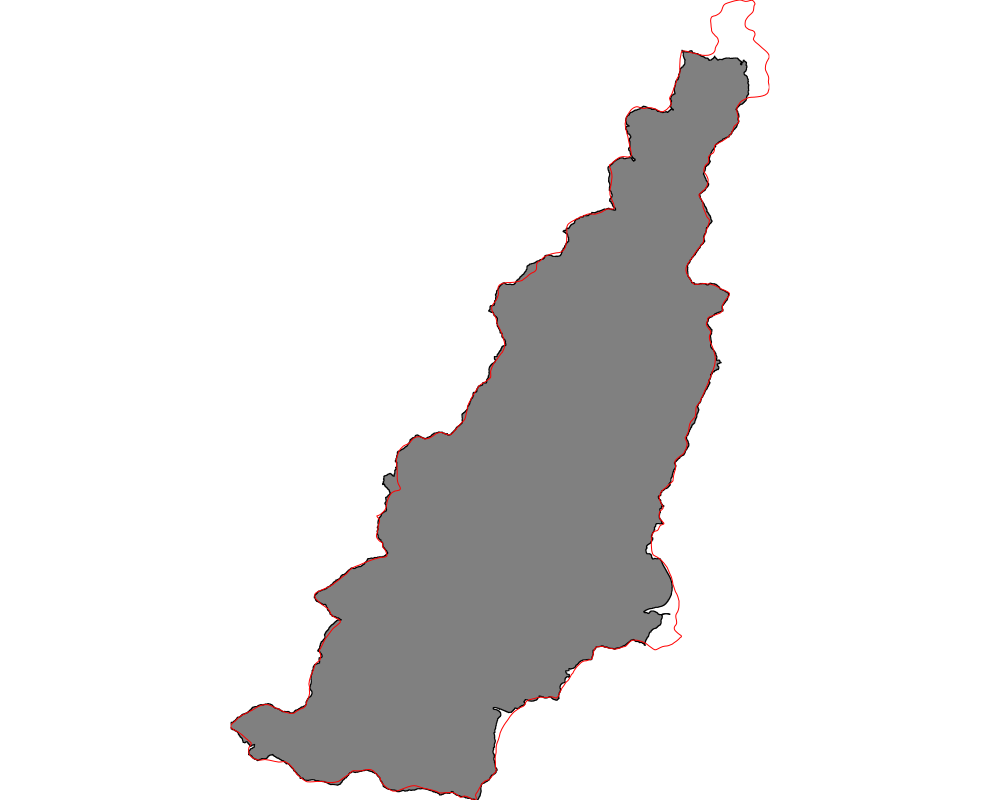

In [18]:
os.environ['GRASS_RENDER_WIDTH'] ='1000' #the width of the image map (default is 640).
os.environ['GRASS_RENDER_HEIGHT']='800' #the height of the image map (default is 480).
region = gs.parse_command('g.region',vector = upstream_huc12s, flags='pg')
gs.run_command('d.erase')
# gs.run_command('d.rast', map='compiled_basins')
gs.run_command('d.vect', map='v_basins_cl',color='black',fill_color='gray')
gs.run_command('d.vect', map=upstream_huc12s,color='red',fill_color='none')
Image(filename="map.png")

# END

# IN DEVELOPMENT

## Populate Area information for basins

## Export Domains and breakline information per model area

In [17]:
##export consolidated basins by HUC scale
##create stream lines for breaklines (use passa H20 method)